## Gradient Boosting Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

def income_model_data_prep(data):
    data = pd.get_dummies(
        income.assign(
                target = np.where(data["SalStat"]==" less than or equal to 50,000", 0,1),
                nativecountry = data["nativecountry"].str.replace(" Holand-Netherlands",
                                                         " Germany"),
                JobType = data["JobType"].replace({" Never-worked":" Without-pay"}),
                occupation = data["occupation"].str.replace(" Armed-Forces"," ?")
                ).drop("SalStat",axis=1),
        drop_first=True
    )
    X = data.drop(columns=["target"],axis=1)
    y = data["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    return X_train, X_test, y_train, y_test

In [3]:
## Split train and test datasets

income = pd.read_csv("../Data/income.csv")

X_train, X_test, y_train, y_test = income_model_data_prep(income)

In [4]:
## fir the dataset with a gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=1023)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1023)

In [5]:
print(f'Train accuracy: {gbm.score(X_train, y_train)}')
print(f'Test accuracy: {gbm.score(X_test, y_test)}')

Train accuracy: 0.8666249706825111
Test accuracy: 0.8672607879924953


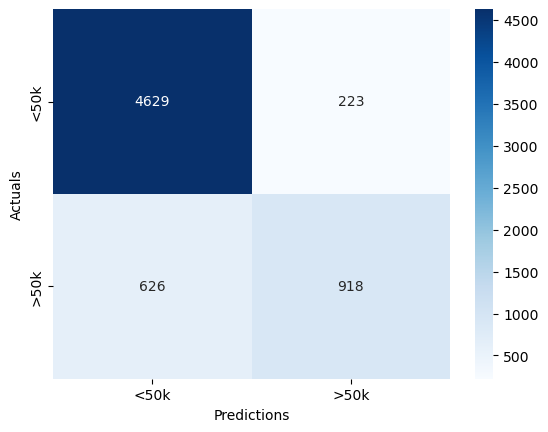

In [6]:
from sklearn.metrics import confusion_matrix
sns.heatmap(
    confusion_matrix(y_test, gbm.predict(X_test)),
    annot=True,
    fmt='.0f',
    cmap='Blues',
    xticklabels=['<50k','>50k'],
    yticklabels=['<50k','>50k']
    # vmax = 1,
    # vmin = -1
)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show();

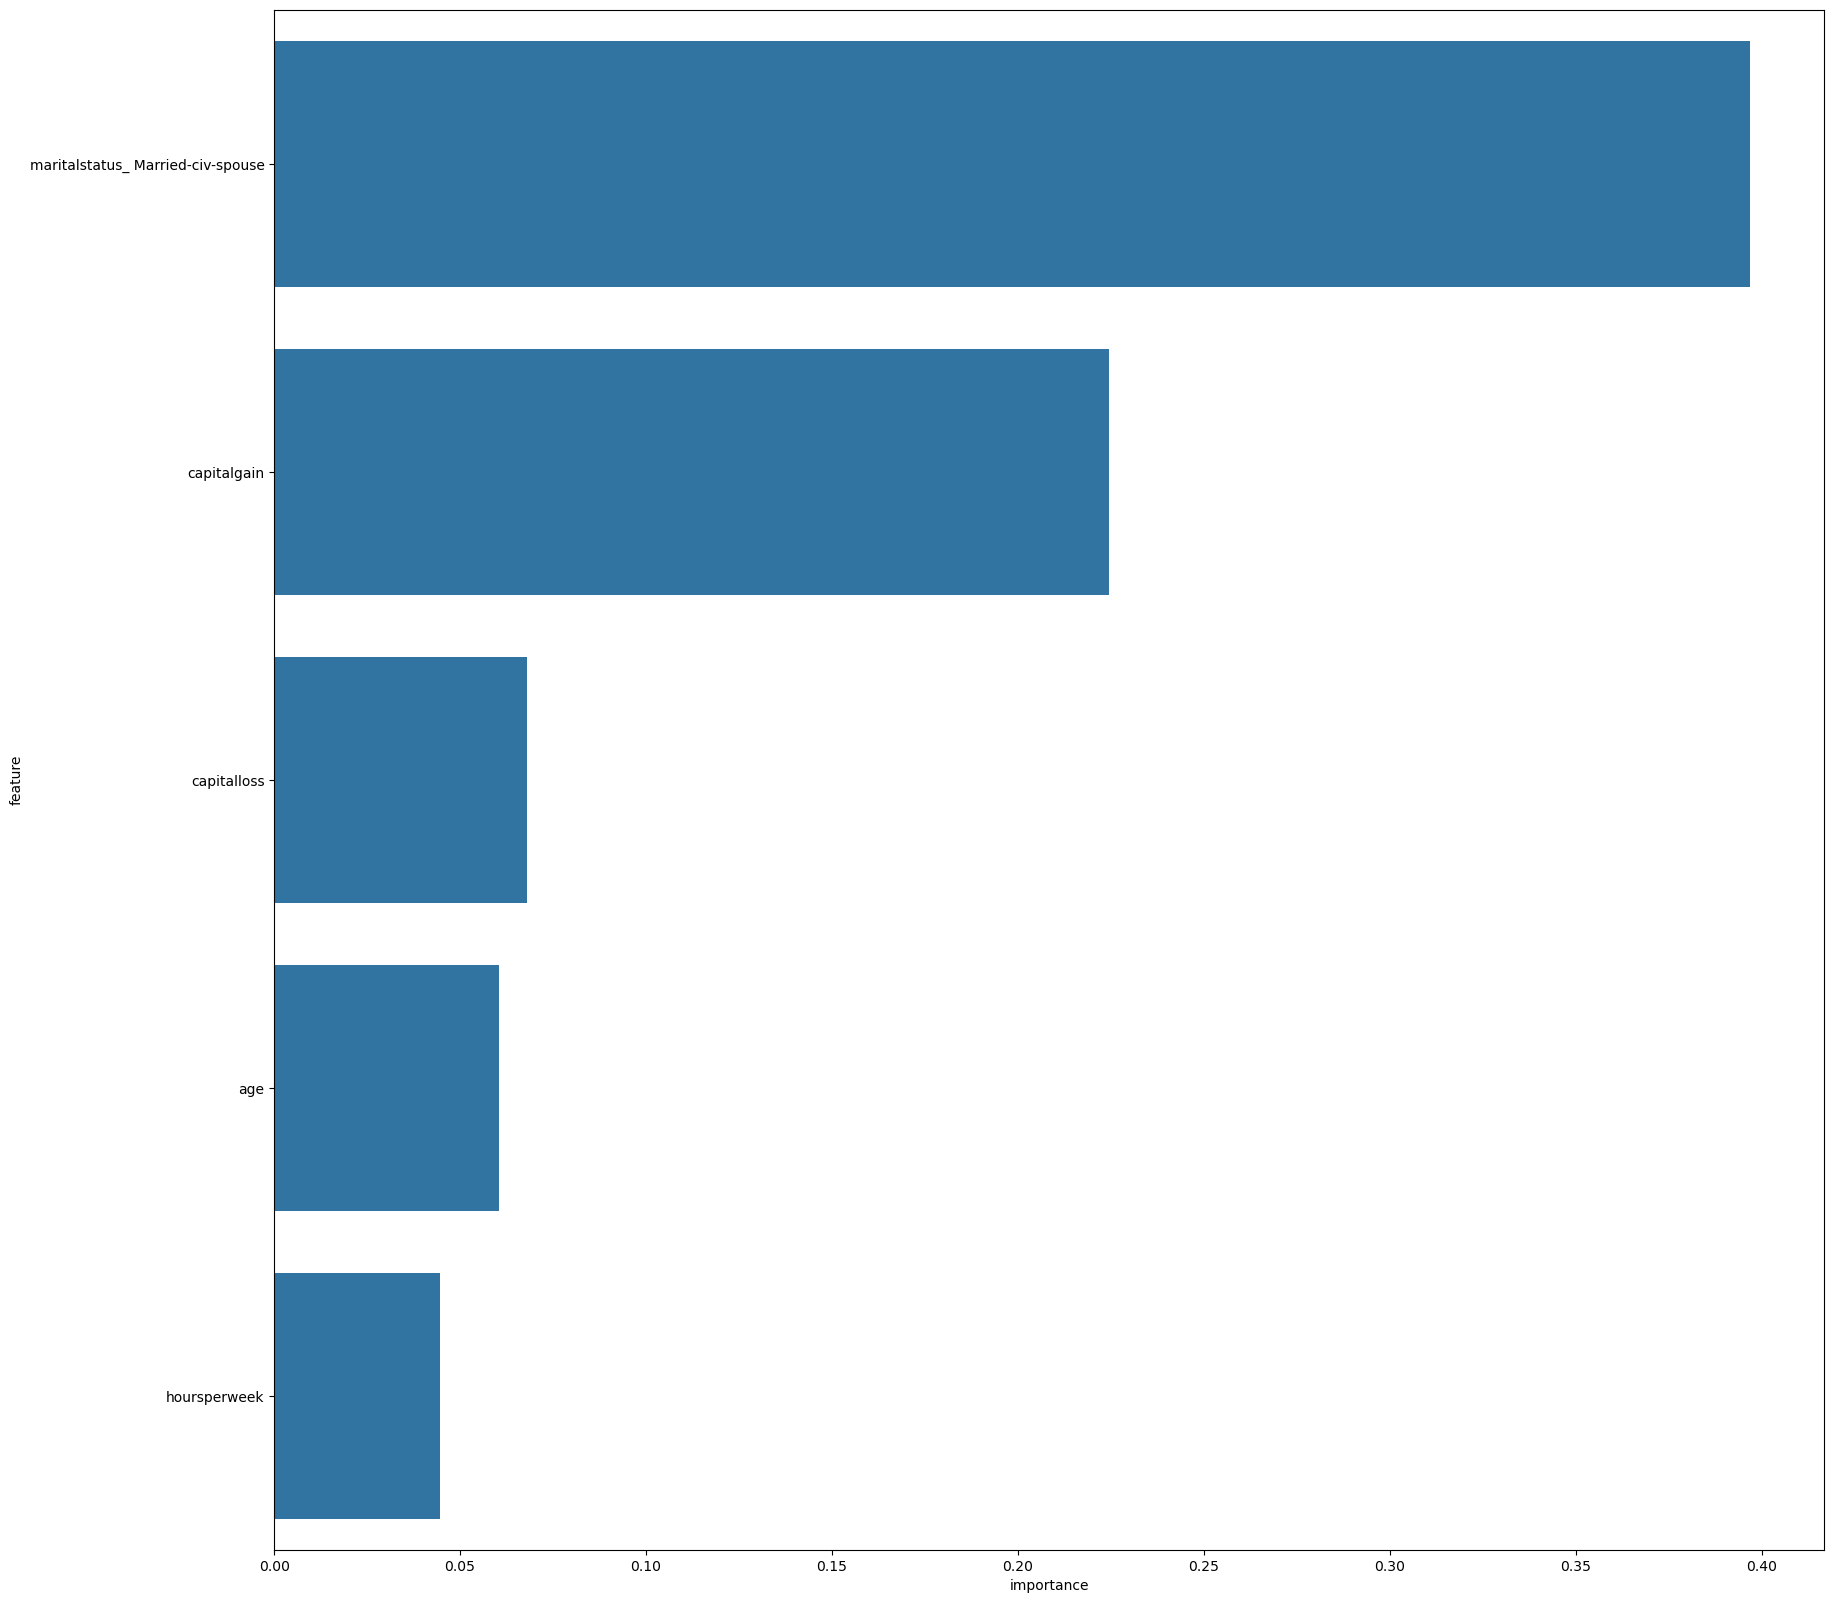

In [7]:
df = pd.DataFrame(
    {"feature":X_train.columns,
     "importance": gbm.feature_importances_},
).sort_values('importance', ascending=False)

fig = plt.figure(figsize=(20,20))
sns.barplot(
    data=df[:5],
    x='importance',
    y='feature'
)
plt.show();

### Tuning the model with hyperparameters

In [8]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": np.arange(100,1100,100),
    "learning_rate": [.001, .01],
    "max_features": [None, "sqrt"],
    "subsample": [.8, .9, 1.0],
    "max_depth": np.arange(3, 12, 2),
    "min_samples_leaf": [2, 5, 10]
}

grid = RandomizedSearchCV(
    gbm,
    param_distributions=params,
    n_iter=10,
    n_jobs=-1,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

{'subsample': 0.9,
 'n_estimators': np.int64(1000),
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': np.int64(11),
 'learning_rate': 0.01}

In [9]:
gb = GradientBoostingClassifier(**grid.best_params_)
gb.fit(X_train, y_train)

print(f'Train accuracy: {gb.score(X_train, y_train)}')
print(f'Test accuracy: {gb.score(X_test, y_test)}')

Train accuracy: 0.895004299898366
Test accuracy: 0.8725766103814885


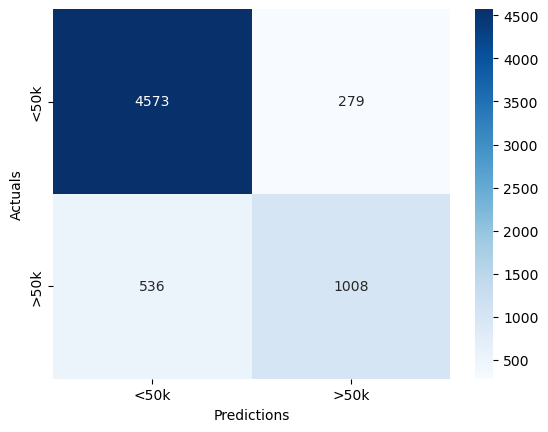

In [11]:
from sklearn.metrics import confusion_matrix
sns.heatmap(
    confusion_matrix(y_test, gb.predict(X_test)),
    annot=True,
    fmt='.0f',
    cmap='Blues',
    xticklabels=['<50k','>50k'],
    yticklabels=['<50k','>50k']
    # vmax = 1,
    # vmin = -1
)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show();

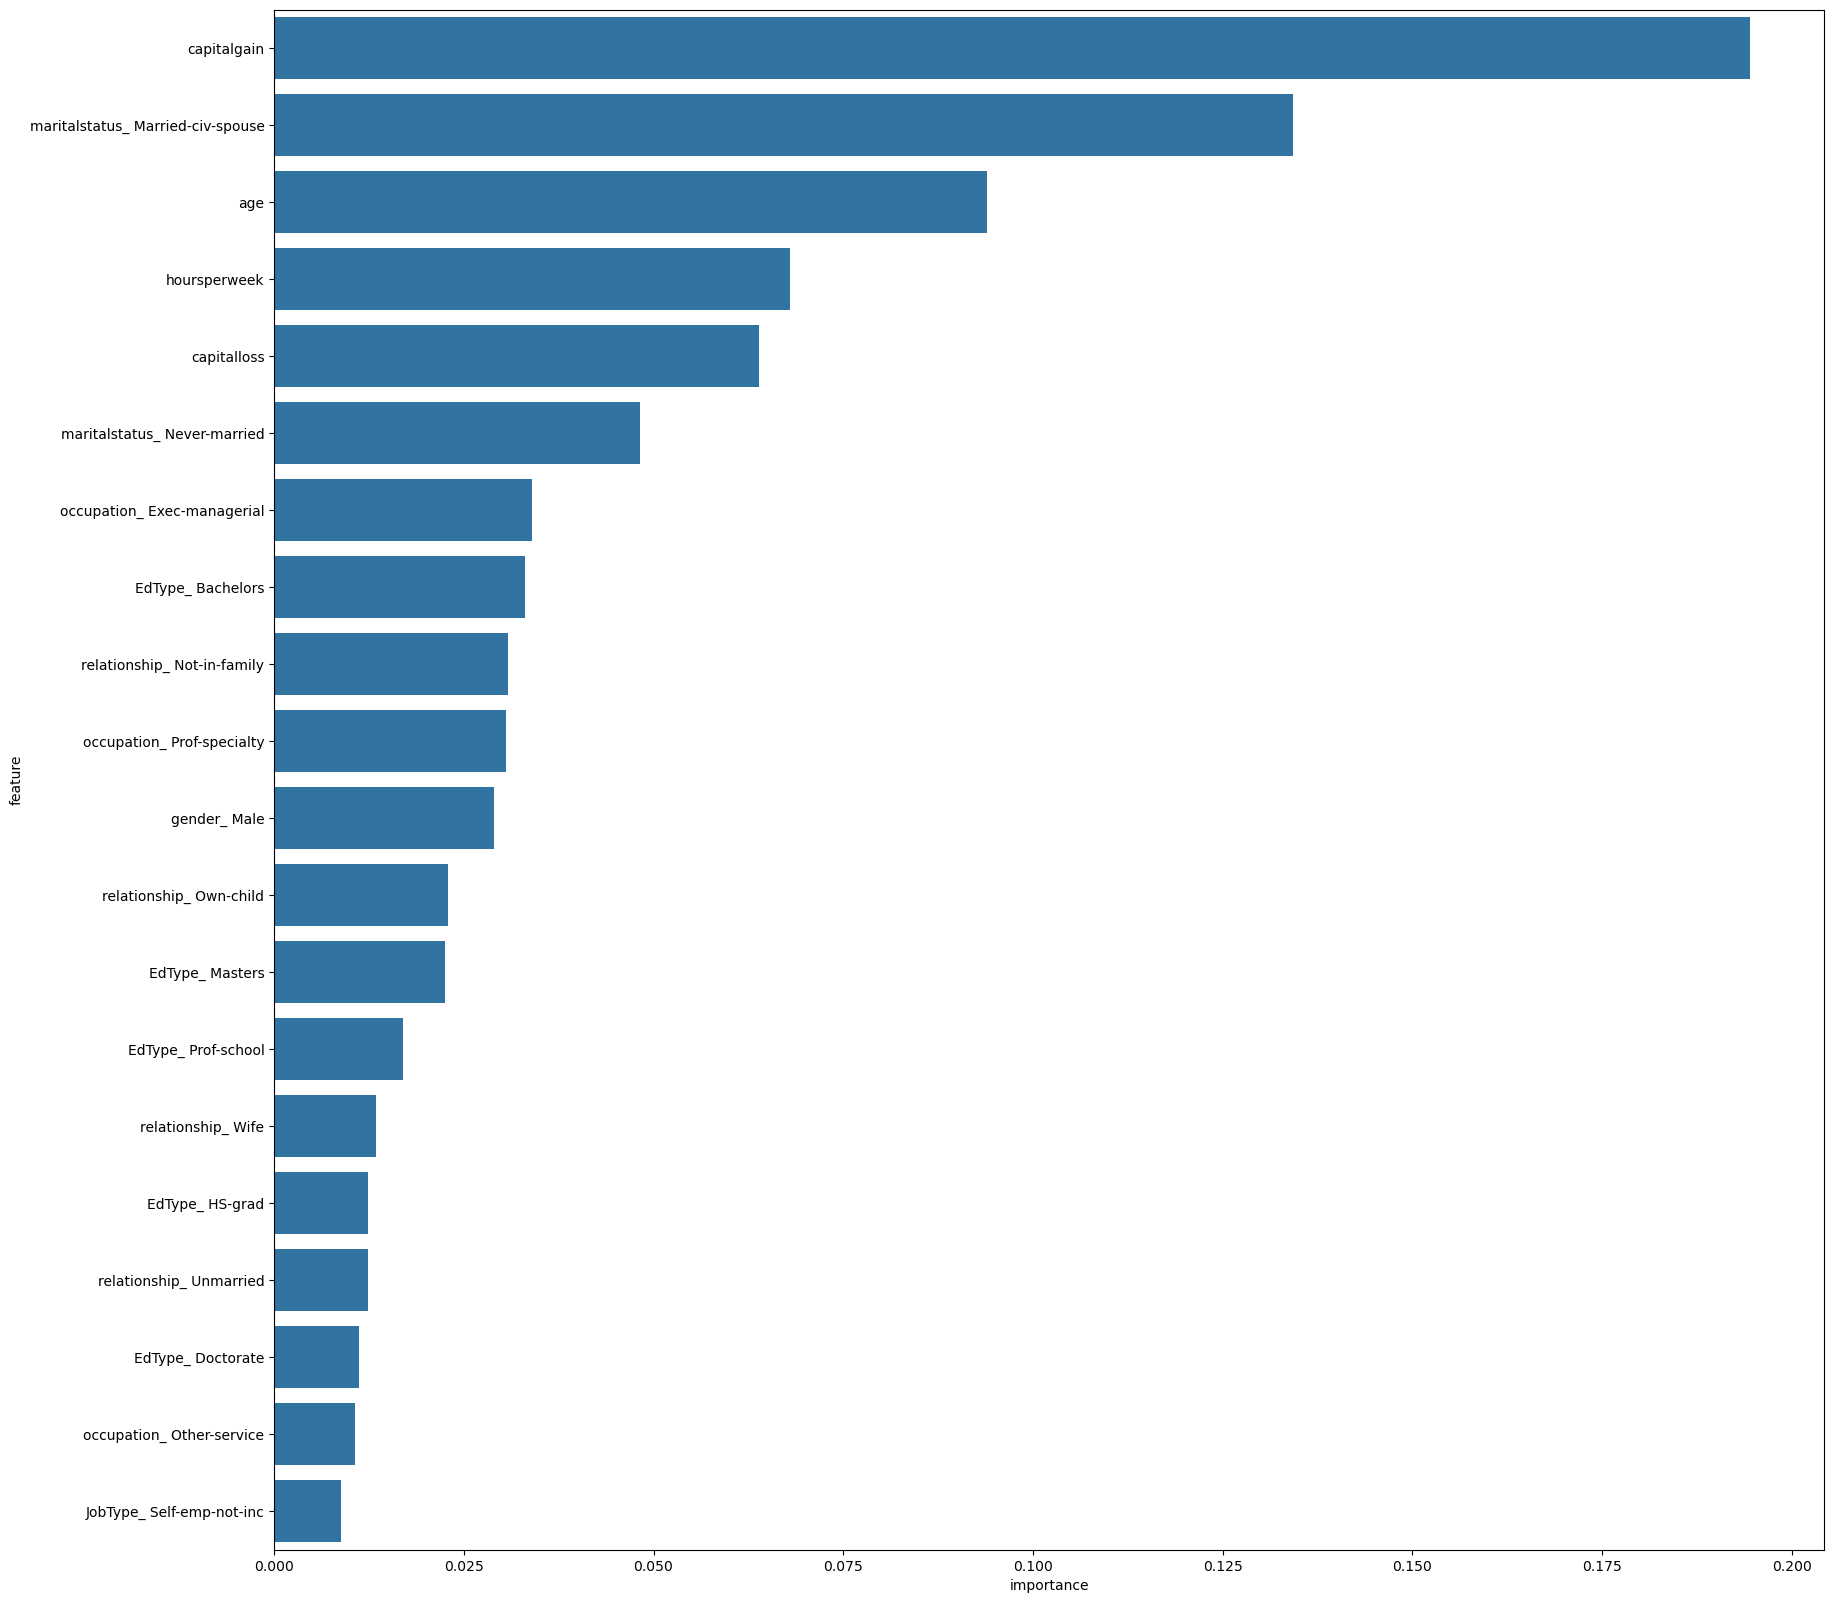

In [12]:
df = pd.DataFrame(
    {"feature":X_train.columns,
     "importance": gb.feature_importances_},
).sort_values('importance', ascending=False)

fig = plt.figure(figsize=(20,20))
sns.barplot(
    data=df[:20],
    x='importance',
    y='feature'
)
plt.show();

In [15]:
#ROC-AUC curve
from sklearn.metrics import roc_curve, auc

y_probs = gb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

auc_score = auc(fpr, tpr)


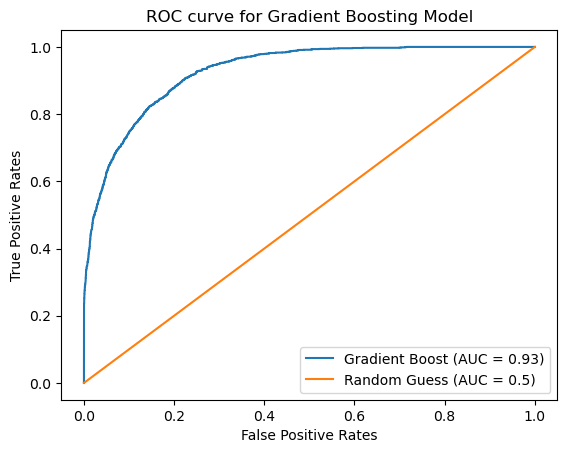

In [16]:
#Plot ROC curve
plt.plot(fpr, tpr, label=f'Gradient Boost (AUC = {auc_score:0.2f})')

#Draw Random Guess
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')

#Format the axes
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.title('ROC curve for Gradient Boosting Model')
plt.legend()
plt.show();